In [1]:
import random
from random import shuffle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as k

from pathlib import Path
import os
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
from scipy import stats

import warnings

tf.config.list_physical_devices('GPU')

warnings.filterwarnings("ignore")

np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16325084689458101515
 xla_global_id: -1]

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## **Funciones**

    Separar en entrenamiento y validacion

In [4]:
def organize_and_split_files(d_raiz, d_entrenamiento, d_validacion, rango_corte, t_datos_entrenamiento=0.8):
    try:
        # Listar todas las carpetas dentro del rango especificado
        for folder in os.listdir(d_raiz):
            if os.path.isdir(os.path.join(d_raiz, folder)) and rango_corte[0] <= folder <= rango_corte[1]:
                folder_path = os.path.join(d_raiz, folder)
                files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
                
                # Desordenar los archivos para una división aleatoria
                shuffle(files)
                
                # Calcular el índice de corte para la división entrenamiento-validación
                split_index = int(len(files) * t_datos_entrenamiento)
                train_files = files[:split_index]
                validation_files = files[split_index:]
                
                # Crear directorios específicos de carpeta dentro de train y validation
                train_folder_path = os.path.join(d_entrenamiento, folder)
                validation_folder_path = os.path.join(d_validacion, folder)
                os.makedirs(train_folder_path, exist_ok=True)
                os.makedirs(validation_folder_path, exist_ok=True)
                
                # Mover archivos a los directorios de entrenamiento y validación
                for file in train_files:
                    shutil.move(os.path.join(folder_path, file), os.path.join(train_folder_path, file))
                
                for file in validation_files:
                    shutil.move(os.path.join(folder_path, file), os.path.join(validation_folder_path, file))
                
                # Eliminar la carpeta original si está vacía
                if not os.listdir(folder_path):
                    os.rmdir(folder_path)
    
    except Exception as e:
        print(f"Error al organizar y dividir los datos: {e}")

    Especificidad

In [5]:
def specificity(y_true, y_score):
    threshold=0.5
    y_pred = tf.cast(tf.greater(y_score, threshold), tf.float32)
 
 
    true_negatives = tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0))
    num_true_negatives=tf.reduce_sum(tf.cast(true_negatives, tf.float32))
 
 
    negatives =tf.equal(y_true, 0)
    num_negatives= tf.reduce_sum(tf.cast(negatives, tf.float32))
 
 
    specificity = num_true_negatives / (num_negatives + tf.keras.backend.epsilon())
     
    return specificity

    Crear modelo

In [6]:
def create_model_con_bn(learning_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),
        
        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', specificity])
    return model

In [7]:
def create_model_sin_bn(learning_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', specificity])
    return model

    Intervalo de confianza

In [8]:
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    margin = sem * stats.t.ppf((1 + confidence) / 2, len(data) - 1)
    return mean, mean - margin, mean + margin

    Graficas

In [9]:
def get_metrics_and_confidence_intervals(histories, metric='sensitivity_at_sensitivity'):
    metrics = []
    for history in histories:
        values = history.history[f'val_{metric}']
        best_epoch_value = max(values)
        mean, lower, upper = confidence_interval(values)
        metrics.append((best_epoch_value, mean, lower, upper))
    return metrics

In [10]:
def plot_metrics(histories, metric):
    plt.figure(figsize=(14, 8))
    for history, model_info in zip(histories, models):
        train_values = history.history[metric]
        val_values = history.history['val_' + metric]
        epochs = range(1, len(train_values) + 1)

        plt.plot(epochs, train_values, label=f'Train {model_info[1]}')
        plt.plot(epochs, val_values, '--', label=f'Val {model_info[1]}')

    plt.title(f'Training and Validation {metric.capitalize()} for All Models')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

## **1. Separar Imagenes en Train/Test**

In [11]:
# Directorios principales
d_raiz = './DATA'

# Directorios para datos de entrenamiento y validación
train_menores = './DATA/train/menores_18'
validation_menores = './DATA/validation/menores_18'
train_mayores = './DATA/train/mayores_18'
validation_mayores = './DATA/validation/mayores_18'

# Dividir datos para menores de 18
organize_and_split_files(d_raiz, train_menores, validation_menores, ('001', '018'))

# Dividir datos para mayores de 18
organize_and_split_files(d_raiz, train_mayores, validation_mayores, ('019', '110'))

print("Proceso de organización y división de archivos completado.")

Proceso de organización y división de archivos completado.


## **2. Preparacion de los datos**

In [12]:
# Definir las rutas a los directorios de datos
train_dir = './DATA/train'
validation_dir = './DATA/validation'

# Crear datasets de imágenes
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=True)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=False)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7778 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## **3. Entrenamiento del modelo**

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

In [15]:
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64]
use_batch_norm_options = [True, False]

models = []
histories = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for use_bn in use_batch_norm_options:
            if use_bn == True:
                model = create_model_con_bn(lr)
                history = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpoint])
                models.append((model, f"LR={lr}, BS={batch_size}, BN={use_bn}"))
                histories.append(history)
            if use_bn == False:
                model = create_model_sin_bn(lr)
                history = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpoint])
                models.append((model, f"LR={lr}, BS={batch_size}, BN={use_bn}"))
                histories.append(history)

Epoch 1/5
244/244 [==============================] - 498s 2s/step - loss: 0.6338 - accuracy: 0.6638 - specificity: 0.8223 - val_loss: 0.8782 - val_accuracy: 0.4730 - val_specificity: 0.2822
Epoch 2/5
244/244 [==============================] - 487s 2s/step - loss: 0.4520 - accuracy: 0.7939 - specificity: 0.8954 - val_loss: 1.1149 - val_accuracy: 0.6200 - val_specificity: 0.5868
Epoch 3/5
244/244 [==============================] - 488s 2s/step - loss: 0.3458 - accuracy: 0.8538 - specificity: 0.9271 - val_loss: 0.5506 - val_accuracy: 0.7845 - val_specificity: 0.4012
Epoch 4/5
244/244 [==============================] - 487s 2s/step - loss: 0.3063 - accuracy: 0.8710 - specificity: 0.9306 - val_loss: 0.3371 - val_accuracy: 0.8565 - val_specificity: 0.4957
Epoch 5/5
244/244 [==============================] - 490s 2s/step - loss: 0.2944 - accuracy: 0.8762 - specificity: 0.9264 - val_loss: 0.4938 - val_accuracy: 0.8010 - val_specificity: 0.5501
Epoch 1/5
244/244 [==============================]

KeyboardInterrupt: 

## **4. Realizar graficas**

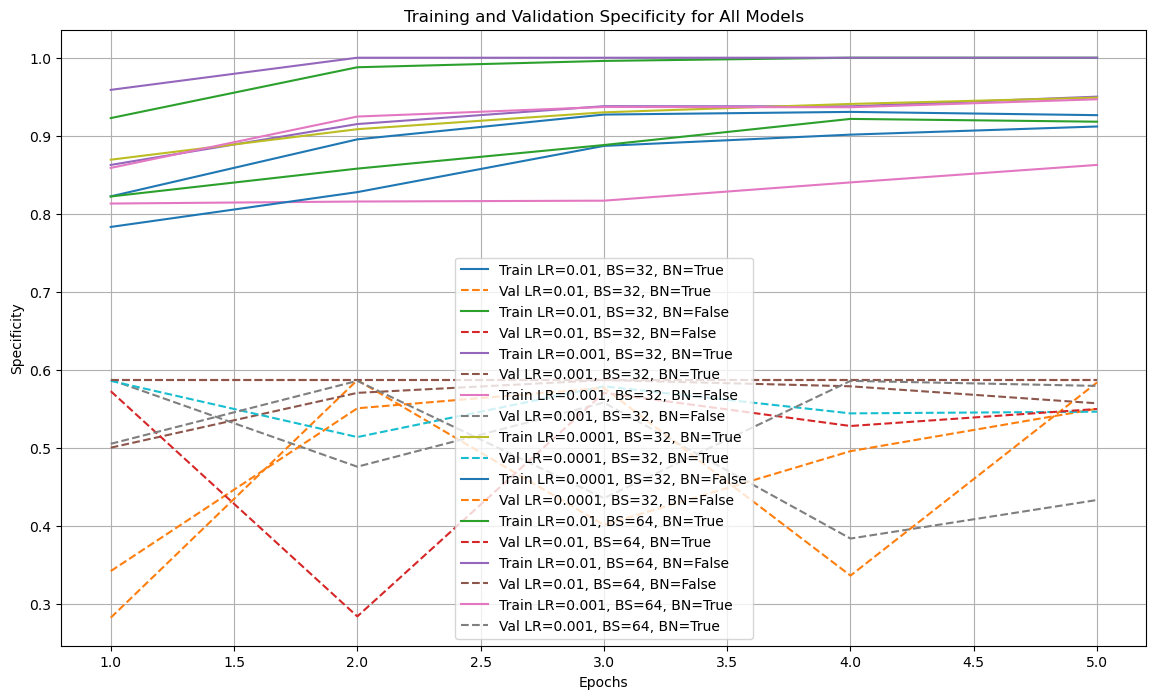

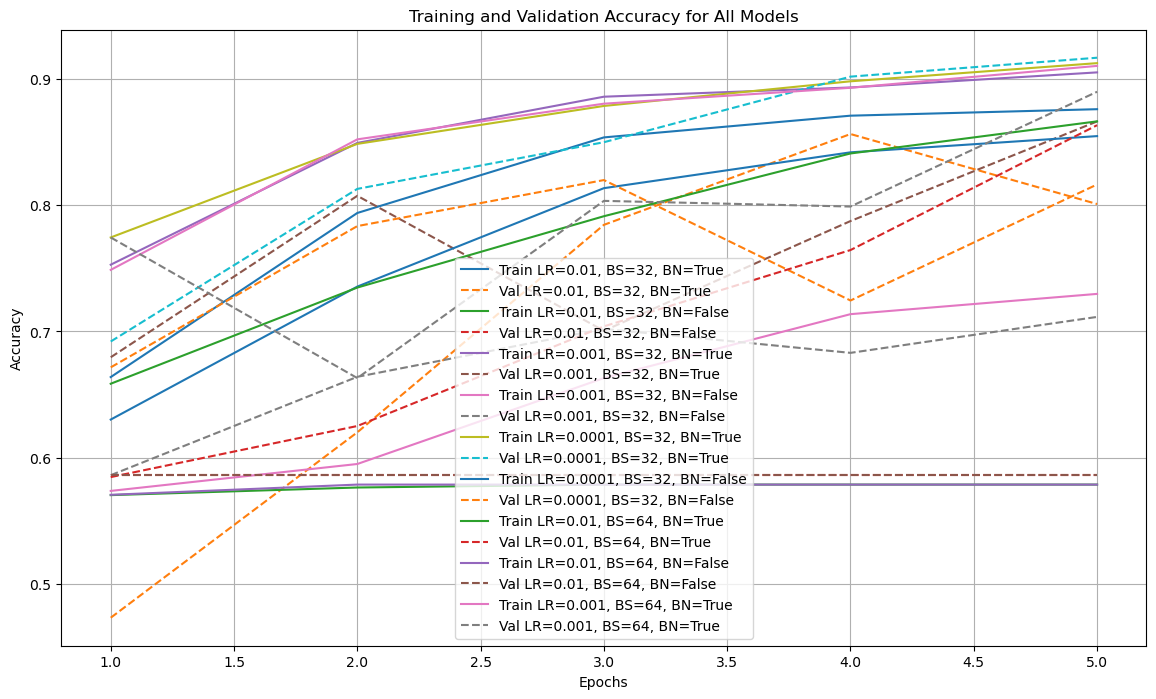

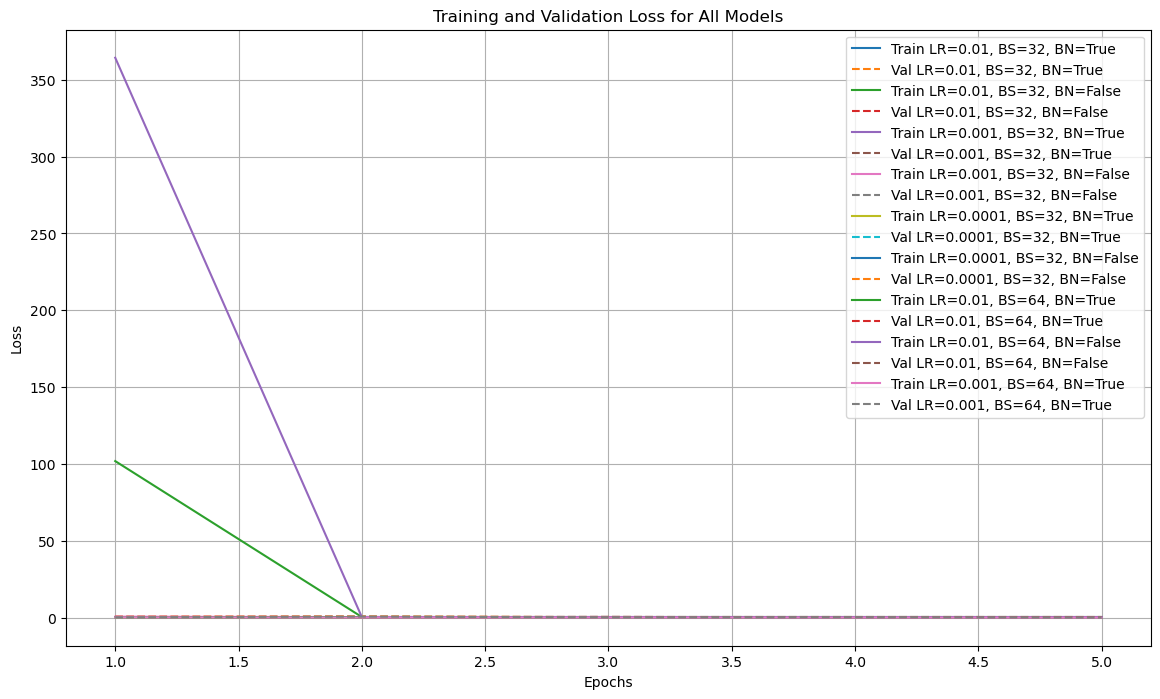

In [16]:
plot_metrics(histories, 'specificity')  # Graficar la especificidad
plot_metrics(histories, 'accuracy')     # Graficar la precisión
plot_metrics(histories, 'loss')         # Graficar la pérdida